# Notebook 5: Clustering

## Learning goals
The goal of this notebook is to familiarise the reader with the implementation of clustering algorithms using the scikit-learn package. 

## Practical clustering methods
We will look at some of the clustering methods we introduced in class ($K$-means, hierarchical clustering and DBSCAN) using [scikit-learn](http://scikit-learn.org/stable/index.html) implementation. We will study our favorite dataset (Ising model) along with some artificial datasets. More generally, the reader is encouraged to explore the incredible scikit learn [example library](http://scikit-learn.org/stable/auto_examples/index.html).


## Ising model - K-means clustering
Let us import the relevant libraries

In [1]:
import pandas as pd
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt 

Let us import the data set. The data set is made of 5000 configuration on a 2D 40x40 Ising lattice.

In [2]:
df1 = pd.read_csv("data/Ising_clustering_comp.csv",header=None) 
df2 = pd.read_csv("data/Ising_clustering_temp.csv",header=None)

Let us minimally manipulate the data.

In [3]:
df1 = df1.to_numpy()
df2 = df2.to_numpy()
principalComponents = df1
t = df2
t = t.T

Let us perform PCA and let us project the data on the first two principal components.

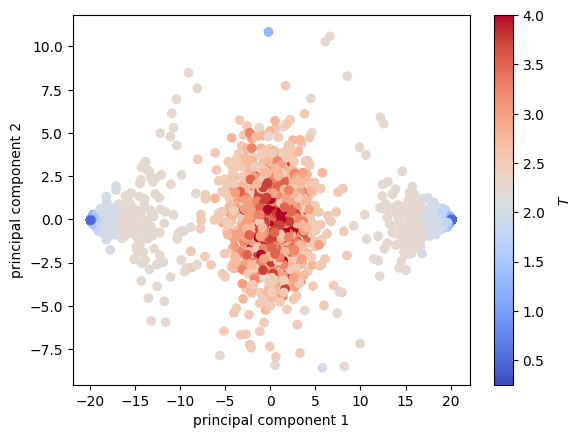

In [4]:
plt.scatter(principalComponents[:,0],principalComponents[:,1],c=t,cmap="coolwarm") 
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
cb = plt.colorbar()
cb.set_label(label='$T$',labelpad=10)
plt.show()
pc = principalComponents

We observe that the data are grouped into three clusters. Let us reconstruct these cluster with the $K$-means algorithm.

Let us import the module that allows us to generate random numbers.

In [5]:
import random

Let us choose the number of clusters.

In [6]:
K=3

Let us choose the cluster means at random.

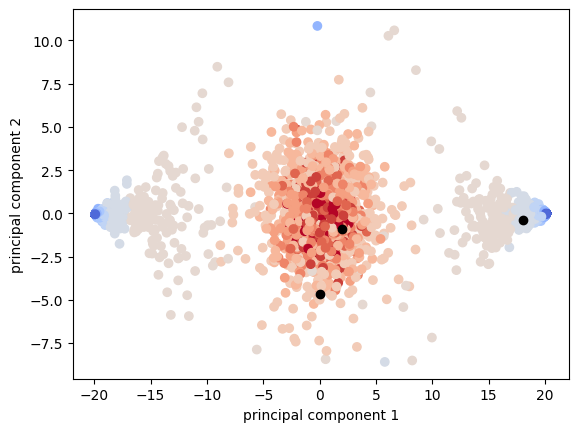

In [7]:
a = random.sample(range(0, len(principalComponents)-1), K)
Centroids = np.zeros((K,2))
for i in range(K):
  Centroids[i,0] = principalComponents[a[i],0]
  Centroids[i,1] = principalComponents[a[i],1]

plt.scatter(principalComponents[:,0],principalComponents[:,1],c=t,cmap="coolwarm")
plt.scatter(Centroids[:,0],Centroids[:,1],c='black')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

Let us construct the dataframe for the cluster means.

In [8]:
principalComponents = principalComponents.tolist()
Centroids = Centroids.tolist()
principalComponents = pd.DataFrame(principalComponents)
Centroids = pd.DataFrame(Centroids)
principalComponents.columns = ['pca1','pca2']
Centroids.columns = ['pca1','pca2']

Now:
- we assign all points to the nearest cluster mean;
- we re-determine the cluster means;
- we repeat these two operations until convergence is reached.

In [9]:
diff = 1
j = 0 

while (diff!=0):
    XD = principalComponents
    i = 1
    for index1,row_c in Centroids.iterrows():
        ED = []
        for index2,row_d in XD.iterrows():
            d1 = (row_c["pca1"] - row_d["pca1"])**2
            d2 = (row_c["pca2"] - row_d["pca2"])**2
            d = np.sqrt(d1+d2)
            ED.append(d)
        principalComponents[i] = ED
        i = i + 1
        
    C=[]
    for index,row in principalComponents.iterrows():
        min_dist = row[1]
        pos = 1
        for i in range(K):
            if row[i+1] < min_dist:
                min_dist = row[i+1]
                pos = i + 1
        C.append(pos)
    principalComponents["Cluster"]=C
    Centroids_new = principalComponents.groupby(["Cluster"]).mean()[["pca2","pca1"]]
    if j == 0:
        diff = 1
        j = j+1
    else:
        diff = (Centroids_new['pca2'] - Centroids['pca2']).sum() + (Centroids_new['pca1'] - Centroids['pca1']).sum()
        print(diff.sum())
    Centroids = principalComponents.groupby(["Cluster"]).mean()[["pca2","pca1"]]

-2.387602116726095
-0.06725809585163973
0.0


Let us draw the results

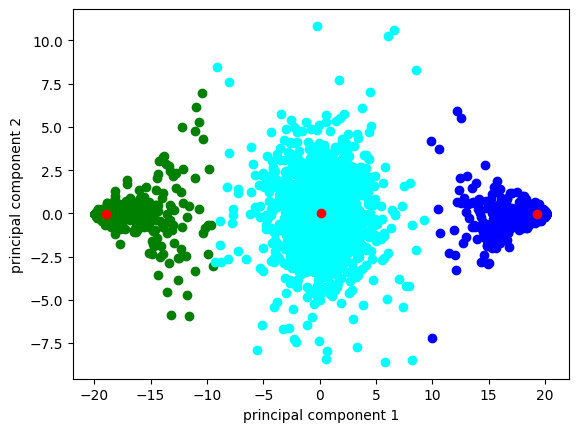

In [10]:
color=['blue','green','cyan','red','yellow']
for k in range(K):
    data=principalComponents[principalComponents["Cluster"]==k+1]
    plt.scatter(data["pca1"],data["pca2"],c=color[k])
plt.scatter(Centroids["pca1"],Centroids["pca2"],c='red')
plt.xlabel('principal component 1')
plt.ylabel('principal component 2')
plt.show()

## Comparing various clustering methods 

This section in the notebook compares different clustering methods on a variety of datasets. All methods are implemented using Scikit Learn. The code is from the aforementioned [example](http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py). 

Automatically created module for IPython interactive environment


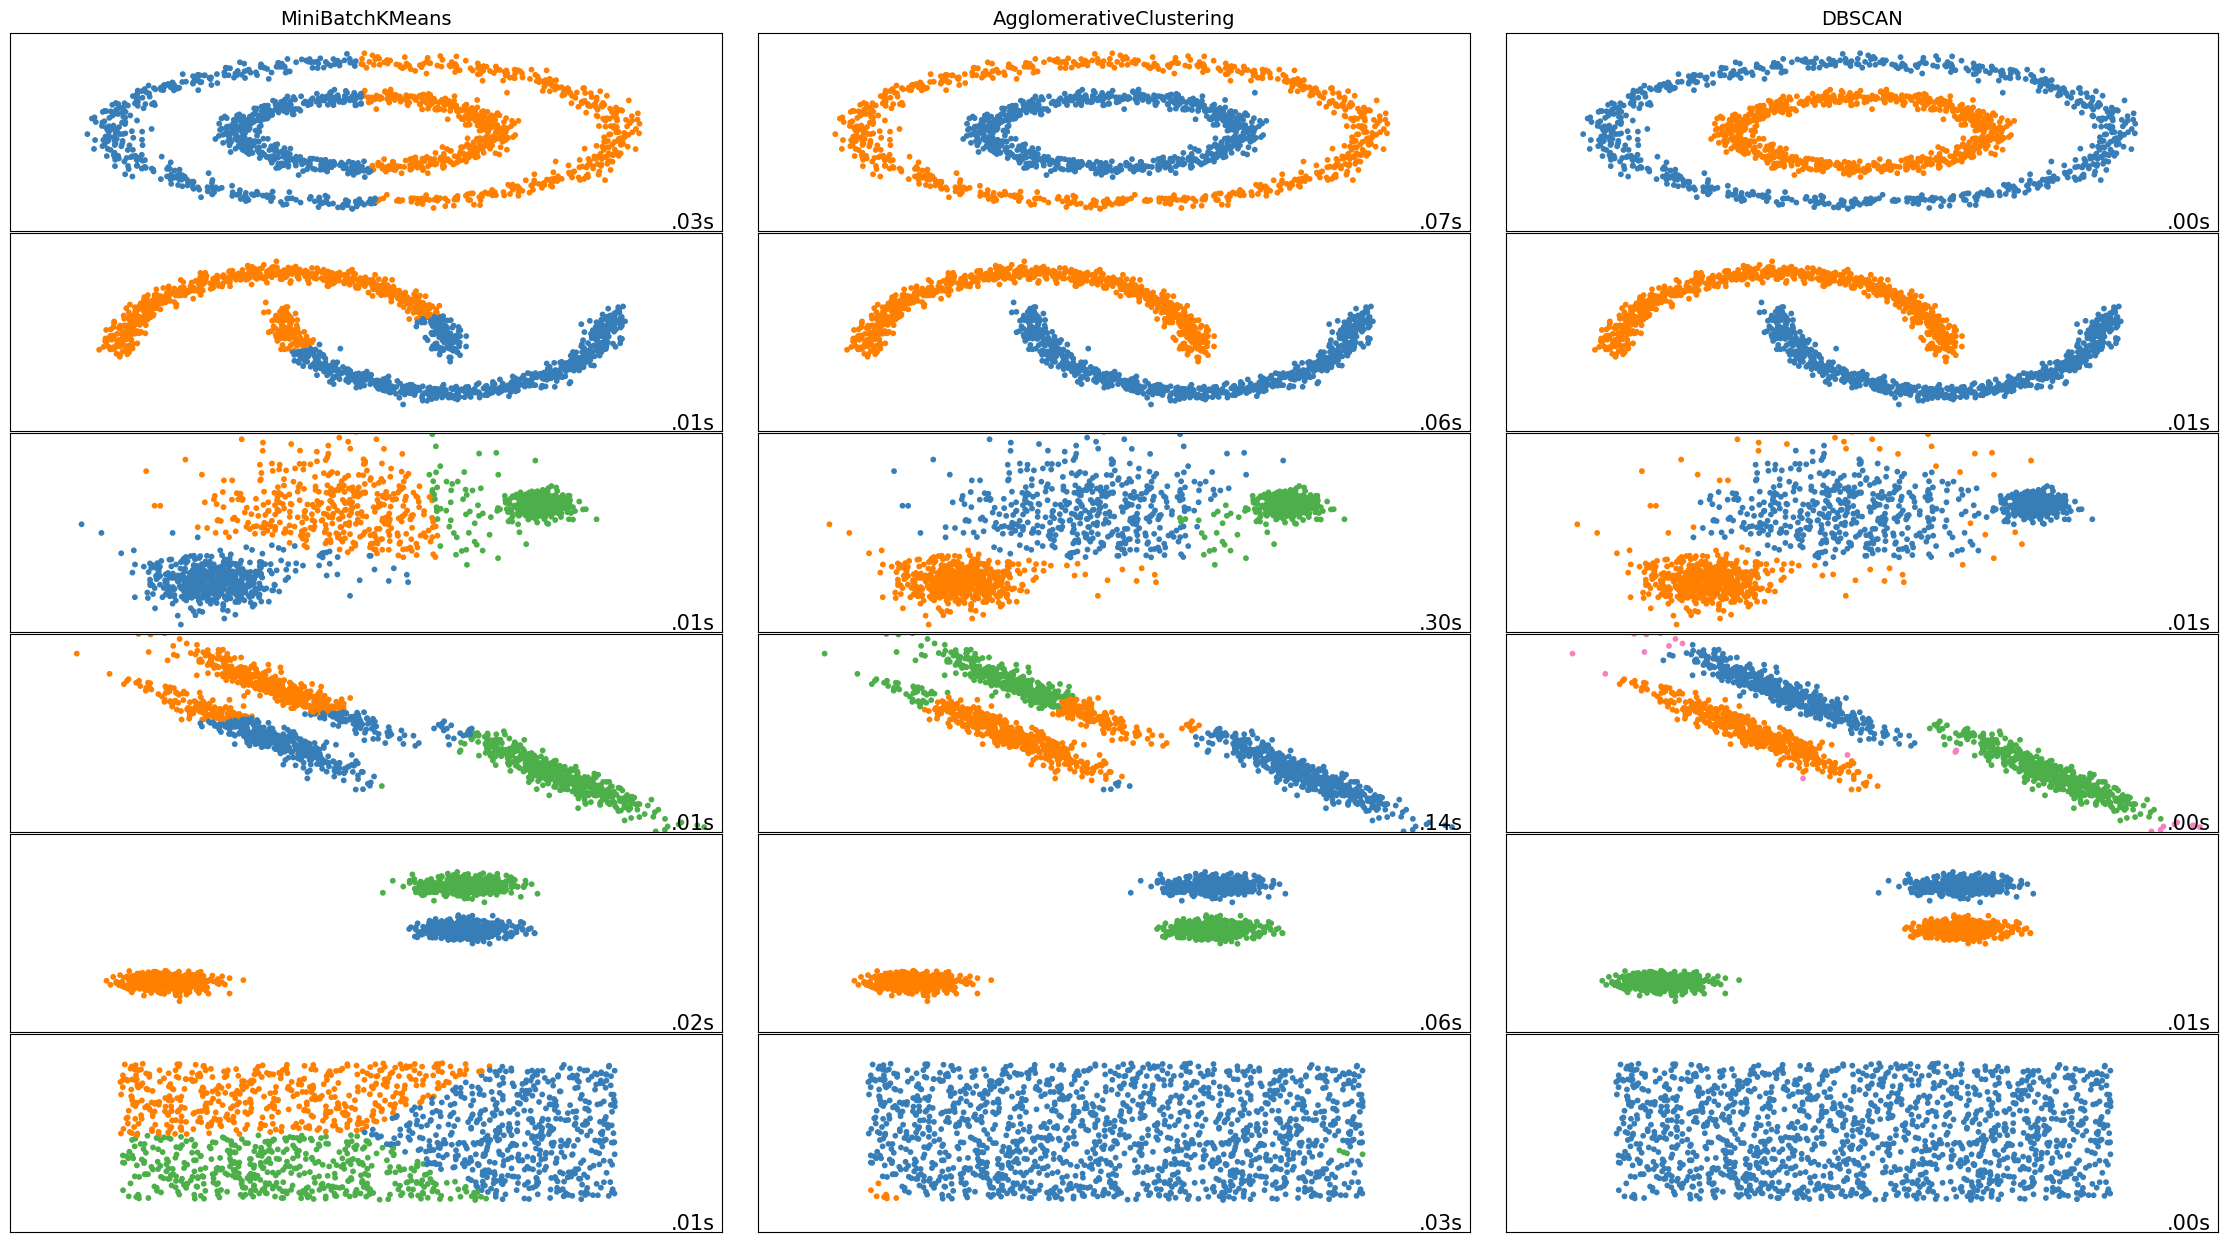

In [11]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',**{'size':16})

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
%matplotlib inline
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 5, 12.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    spectral = cluster.SpectralClustering(
        n_clusters=params['n_clusters'], eigen_solver='arpack')
    dbscan = cluster.DBSCAN(eps=params['eps'])
    affinity_propagation = cluster.AffinityPropagation(
        damping=params['damping'], preference=params['preference'])
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        n_clusters=params['n_clusters'], connectivity=connectivity)
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    gmm = mixture.GaussianMixture(
        n_components=params['n_clusters'], covariance_type='full')
    
    clustering_algorithms = (
        ('MiniBatchKMeans', two_means),
        ('AgglomerativeClustering', average_linkage),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=14)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

In this simple setting, DBSCAN outperforms the other methods both in computational time and in prediction accuracy for almost all cases. DBSCAN fails only for the 3rd dataset (from the top). Note the wide range of qualitatively different datasets used. When tuning a clustering method it is important to understand what the implicit assumption of the clustering method are. For instance, methods based on density (local information), will typically fare well at clustering topological datasets (row 1 and 2) since points are connected from neighbor to neighbor. At the same time, methods based on long-distance information ($K$-means for instance), will typically perform poorly in such instances. Density-based methods will, however, have more difficulty at dealing with datasets with large fluctuations in the density distribution of the dataset (3rd row). Another drawback of density based methods is that they do not generalize well to high-dimensional space due to large sampling noise in the density estimates. 

## Clustering accuracy and clustering algorithm parameters

One way to quantitatively measure the performance of a clustering method is to compare the predicted labels to the ground-truth labels (given that those are available). Here we will use the normalized mutual information (see https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-clustering-1.html for more discussion on the subject and other possible metrics) to perform such comparison. As we will see, when doing clustering, there is usually no free lunch: if one chooses the wrong set of parameters (which can be quite sensitive), the clustering algorithm will likely fail or return a trivial answer (for instance all points assigned to the same cluster).  

In [12]:
from collections import OrderedDict

def clustering(y):
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]
    return clustering

def entropy(c, n_sample):
    # Measures the entropy of a cluster
    h = 0.
    for kc in c.keys():
        p=len(c[kc])/n_sample
        h+=p*np.log(p)
    h*=-1.
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
def NMI(y_true, y_pred):
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)
    c = clustering(y_pred)
    n_sample = len(y_true)

    Iwc = 0.
    for kw in w.keys():
        for kc in c.keys():
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc])))
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc])))
    Iwc/=n_sample
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

Consider again the 2D Gaussian mixture we produced above:

------> Example with 15 true cluster centers <-------


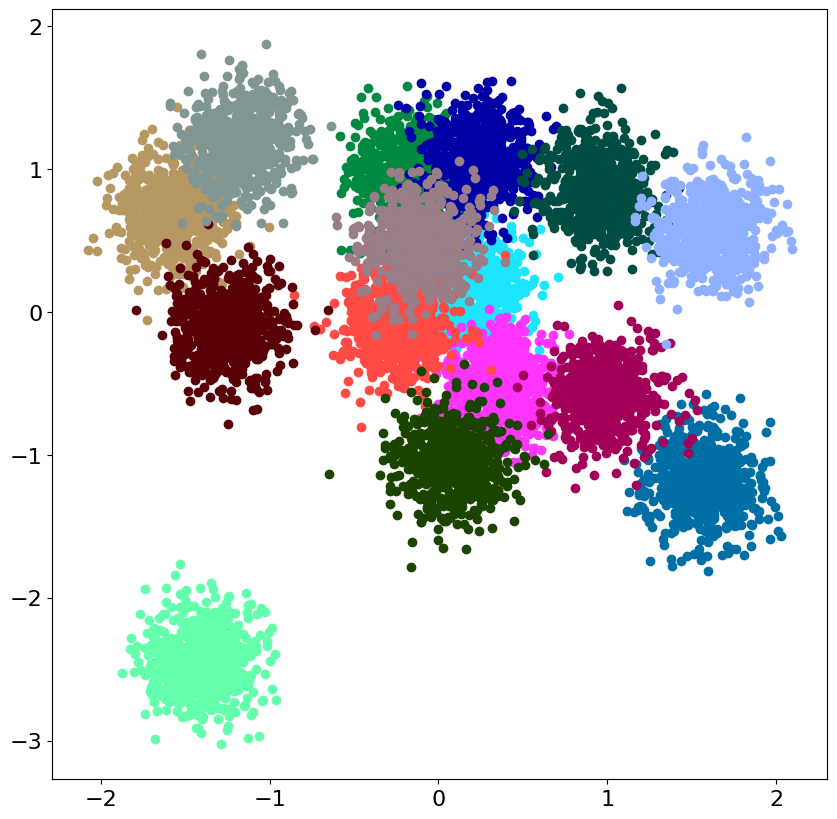

In [13]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

n_true_center = 15

np.random.seed(0)

print("------> Example with %i true cluster centers <-------"%n_true_center)

X, y = make_blobs(n_samples=10000, n_features=2, centers=n_true_center, cluster_std=1, random_state=0) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

cpalette = ["#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

def plot_clustering(X,y):
    plt.figure(figsize=(10,10))
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        plt.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)])
    plt.show()

plot_clustering(X,y)

Let's apply simple clustering methods to this dataset and measure their accuracy.

### $K$-means

$K$-means is a simple clustering methods based on minimizing the inertia of clusters. One tries to find $K$ cluster centers with points tightly distributed around them. $K$-mean has the advantage of being scalable to very large datasets. One of the two main problems with $K$-means is that
    1. K has to be fixed by the user 
    2. K-means can only deal with "convex" clusters

We can measure the performance of K-means by thinking about the *distortion*- the square distance of each point from the centroid defining the cluster. This is the objective function that K-means tries to optimize.

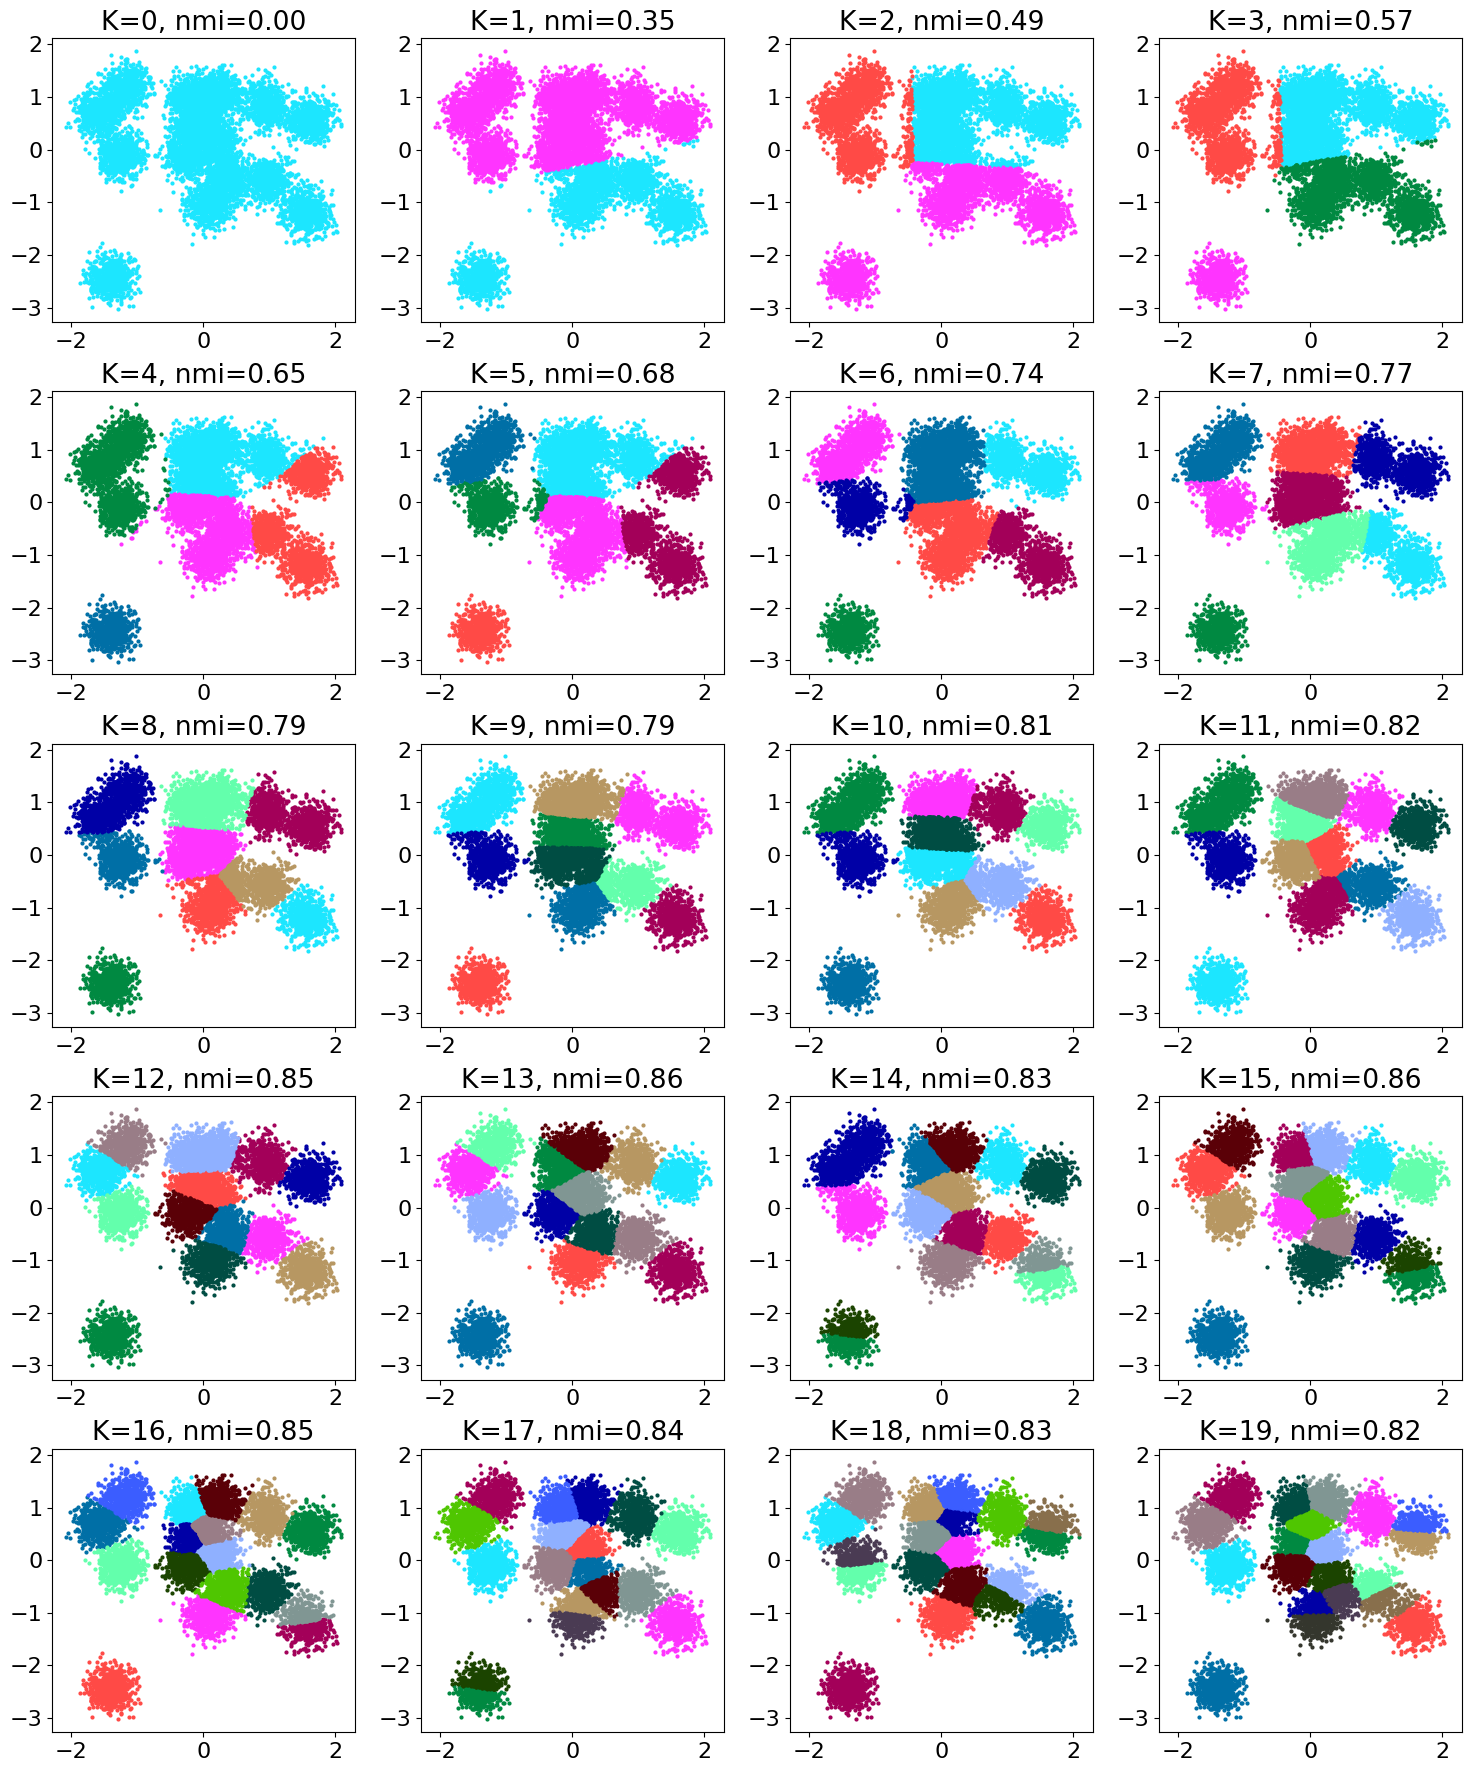

In [14]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue =  make_blobs(n_samples=10000, n_features=2, centers=n_true_center, cluster_std=1, random_state=0)# Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

K_range = np.arange(20).reshape(5,4)
fig, ax = plt.subplots(K_range.shape[0], K_range.shape[1], figsize=(15,18))
distortion = []
for i in range(K_range.shape[0]):
    for j in range(K_range.shape[1]):
        model = KMeans(n_clusters=K_range[i,j]+1)
        model.fit(X)
        y = model.labels_
        plotting_ax(X, y, ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('K=%i, nmi=%.2f'%(K_range[i,j],nmi))
        distortion.append(model.inertia_)
plt.tight_layout(h_pad=0.5)
plt.show()

Finally, let's plot the distortion against the number of clusters. 

We see that $K$-Means does a great job at dealing with Gaussian mixtures of equal variances. The normalized mutual information is maximized at $K=15$. However, one usually does not have access to ground-truth labels. Many simple measures of clustering can be devised to measure clustering accuracy (for instance the distortion, see above). These however tend to be monotonic in the number of clusters. Maximizing/minimizing such metrics will lead 
to trivial solutions. Instead one usually tries to find a point of inflexion (or kink) in the metric, which signifies a major change in the clustering algorithm and can be sometimes associated with the regime of good solutions.

### Density based clustering: DBSCAN
Here we sweep over the main parameters of DBSCAN and compute the normalized mutual information for every assignment found.

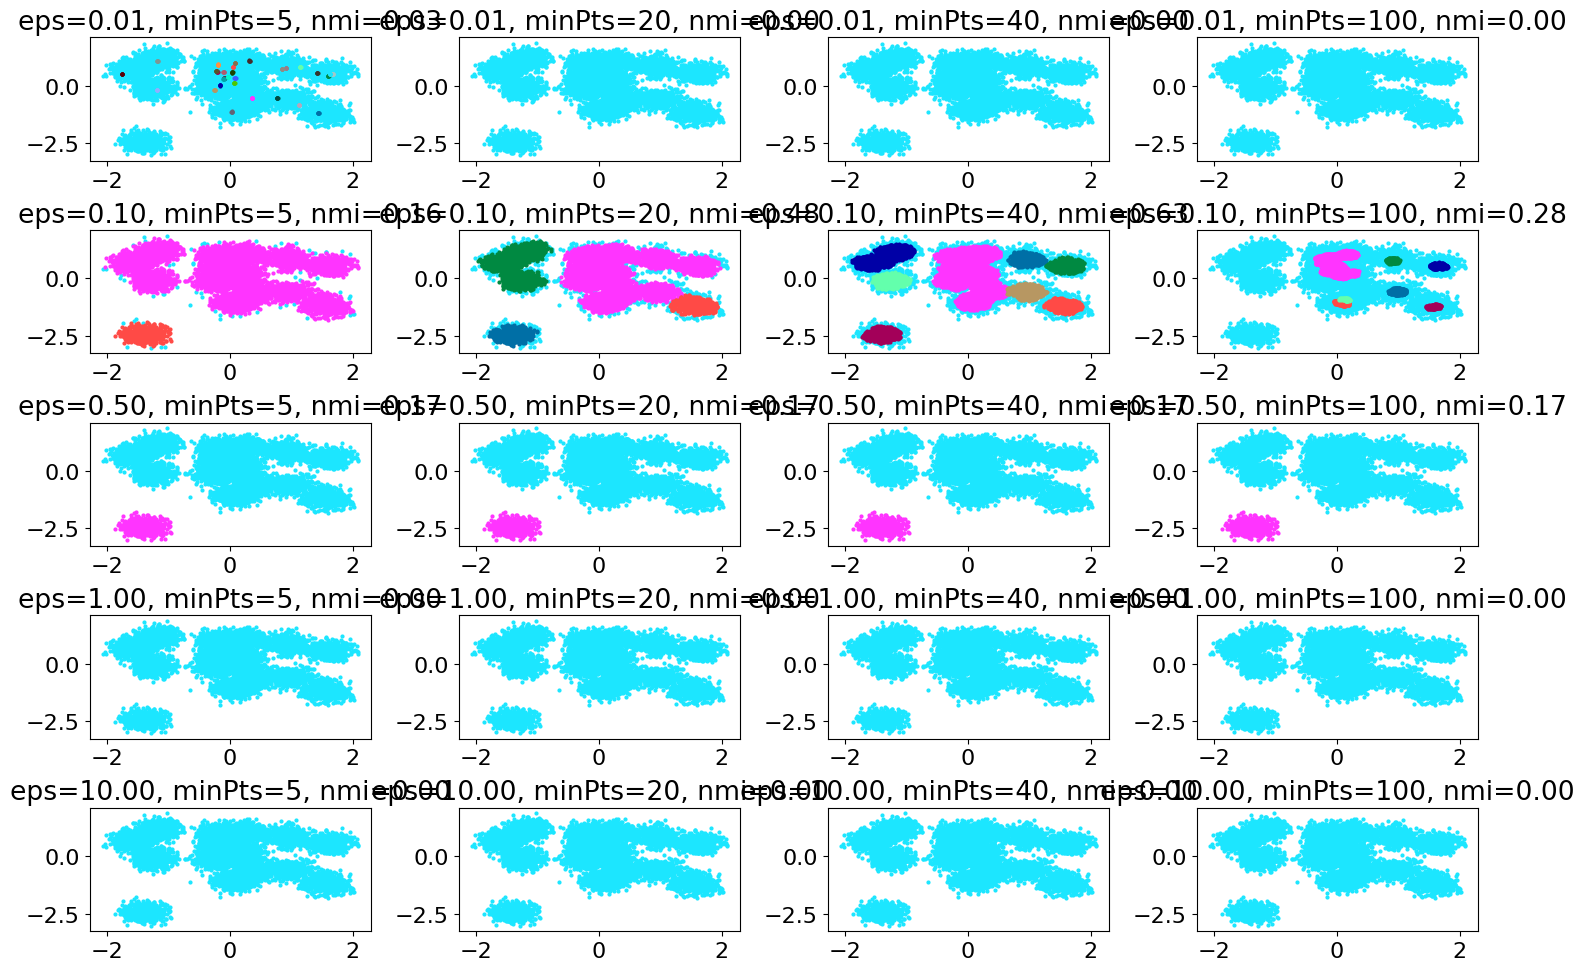

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def plotting_ax(X, y, ax):
    # plotting function
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=4)

# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(0)
n_true_center=15
X, ytrue = make_blobs(n_samples=10000, n_features=2, centers=n_true_center, cluster_std=1, random_state=0) # Generating random gaussian mixture
X = StandardScaler().fit_transform(X)

eps_range = [0.01,0.1,0.5,1.0,10.]
min_sample_range = [5,20,40,100]
fig, ax = plt.subplots(len(eps_range),len(min_sample_range),figsize=(15,10))
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y = model.labels_
        plotting_ax(X,y,ax[i,j])
        nmi=NMI(y, ytrue)
        ax[i,j].set_title('eps=%.2f, minPts=%i, nmi=%.2f'%(eps,min_samples,nmi))
plt.tight_layout(h_pad=0.5)
plt.show()

DBSCAN does a great job of clustering when the parameters are well chosen. `minPts` is responsible for determining what an outsider is (i.e. if a point has less than `minPts` in its epsilon neighborhood, it is not a core-point). `eps` tunes the size of the neighborhood of each point which is just a circle of radius `eps`. 

Note also that obtaining the exact number of clusters or the perfect cluster assignment is usually not what is sought in clustering (since it is usually not possible to do this). Indeed, if two Gaussians (representing two different clusters) have a large overlap, the density function corresponding to the sum of the two Gaussians will effectively look like a single Gaussian and it makes sense to predict a unique cluster in this situation. Given the available information, there is no statistically significant way of separating those two clusters. This scale of separation, i.e. what to consider noise and what to consider distinct clusters, is usually encoded in one of the parameters of density based clustering algorithms.